In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
import pandas as pd
from dataset import MultitaskDataset  # Replace with your actual module name
from sklearn.metrics import roc_auc_score

# Define transformations for training set and validation set
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjusted size for ResNet input
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjusted size for ResNet input
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Parameters
batch_size = 32
num_epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create dataset instance
root_dir = '../../data/BiteCount'  
train_annotation_file = './splits/train.csv'
val_annotation_file = './splits/valid.csv'

train_dataset = MultitaskDataset(root_dir=root_dir, 
                            annotation_file=train_annotation_file,
                            transform=train_transforms,
                            rgb=True)

val_dataset = MultitaskDataset(root_dir=root_dir, 
                            annotation_file=val_annotation_file,
                            transform=val_transforms,
                            rgb=True)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# List of ResNet models to benchmark
resnet_models = {
    'resnet18': models.resnet18(pretrained=True),
    'resnet34': models.resnet34(pretrained=True),
    'resnet50': models.resnet50(pretrained=True),
    'resnet101': models.resnet101(pretrained=True),
    'resnet152': models.resnet152(pretrained=True),
}

# DataFrame to store benchmarking results
results_df = pd.DataFrame(columns=['Model', 'Epoch', 'Val_Loss', 'Val_Accuracy', 'ROC_AUC'])

# Loop over ResNet models
for model_name, model in resnet_models.items():
    print(f"Training {model_name}...")

    # Adjust final fully connected layer for binary classification
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 1)  # Binary classification
    model = model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.8)

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        # Training loop
        for batch in train_loader:
            images = batch['rgb'].to(device)  # Get the RGB images
            labels = batch['label'].to(device).float()  # Convert labels to float for BCEWithLogitsLoss

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs.view(-1), labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize weights

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

        # Evaluation on validation set
        model.eval()  # Set the model to evaluation mode
        val_running_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for batch in val_loader:
                images = batch['rgb'].to(device)  # Get the RGB images
                labels = batch['label'].to(device).float()  # Convert labels to float for BCEWithLogitsLoss

                outputs = model(images)
                val_loss = criterion(outputs.view(-1), labels)
                val_running_loss += val_loss.item()

                # Collect true labels and predicted probabilities
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(torch.sigmoid(outputs).view(-1).cpu().numpy())  # Apply sigmoid to get probabilities

                # Calculate accuracy
                predicted = torch.round(torch.sigmoid(outputs))  # Apply sigmoid to get predictions
                total += labels.size(0)
                correct += (predicted.view(-1) == labels).sum().item()

        avg_val_loss = val_running_loss / len(val_loader)
        val_accuracy = correct / total

        roc_auc = roc_auc_score(all_labels, all_probs)
        print(f"Validation ROC AUC: {roc_auc:.4f}")

        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Create a dictionary for current results
        epoch_result = {
            'Model': model_name,
            'Epoch': epoch + 1,
            'Val_Loss': avg_val_loss,
            'Val_Accuracy': val_accuracy,
            'ROC_AUC': roc_auc
        }

        # Use pd.concat() to add the row to results_df
        results_df = pd.concat([results_df, pd.DataFrame([epoch_result])], ignore_index=True)

        # Save the best model based on validation accuracy
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(model.state_dict(), f'best_{model_name}.pth')

    print(f"Best Validation Accuracy for {model_name}: {best_val_acc:.4f}")

# Save the results dataframe to a CSV file
results_df.to_csv('resnet_benchmark_results.csv', index=False)
print("Benchmarking completed and results saved to resnet_benchmark_results.csv")


Training resnet18...
Epoch [1/1], Loss: 0.7397
Validation ROC AUC: 0.7881
Validation Loss: 0.5795, Validation Accuracy: 0.6641
Best Validation Accuracy for resnet18: 0.6641
Training resnet34...
Epoch [1/1], Loss: 0.7475
Validation ROC AUC: 0.7179
Validation Loss: 0.6760, Validation Accuracy: 0.6295
Best Validation Accuracy for resnet34: 0.6295
Training resnet50...
Epoch [1/1], Loss: 0.7236
Validation ROC AUC: 0.8108
Validation Loss: 0.5877, Validation Accuracy: 0.7104
Best Validation Accuracy for resnet50: 0.7104
Training resnet101...
Epoch [1/1], Loss: 0.6766
Validation ROC AUC: 0.8405
Validation Loss: 0.6093, Validation Accuracy: 0.7936
Best Validation Accuracy for resnet101: 0.7936
Training resnet152...
Epoch [1/1], Loss: 0.6845
Validation ROC AUC: 0.8583
Validation Loss: 0.8045, Validation Accuracy: 0.6719
Best Validation Accuracy for resnet152: 0.6719
Benchmarking completed and results saved to resnet_benchmark_results.csv


In [2]:
results_df.head()

,Model,Epoch,Val_Loss,Val_Accuracy,ROC_AUC
0,resnet18,1,0.579469,0.664050,0.788108
1,resnet34,1,0.675985,0.629513,0.717874
2,resnet50,1,0.587664,0.710361,0.810803
3,resnet101,1,0.609251,0.793564,0.840508
4,resnet152,1,0.804457,0.671900,0.858294


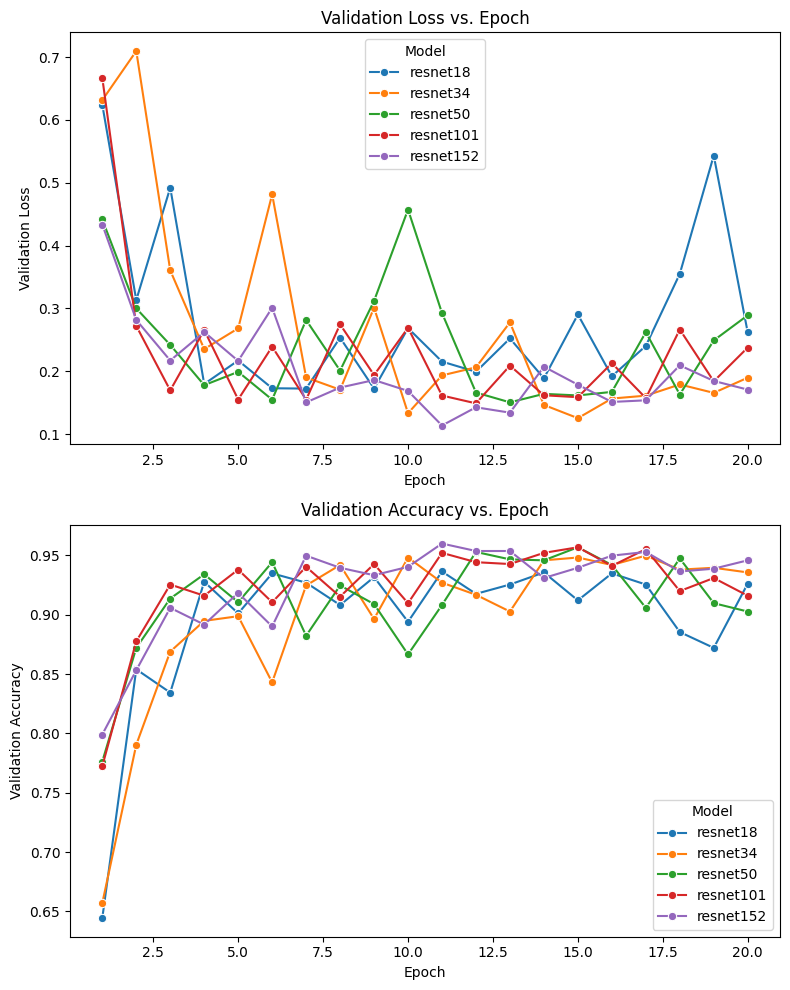

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

results_df = pd.read_csv('resnet_benchmark_results.csv')

# Create a figure with 2 subplots (2 rows, 1 column)
fig, axes = plt.subplots(2, 1, figsize=(8, 10))

# Plot Val_Loss against Epoch
sns.lineplot(x='Epoch', y='Val_Loss', hue='Model', marker='o', data=results_df, ax=axes[0])
axes[0].set_title('Validation Loss vs. Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Validation Loss')

# Plot Val_Accuracy against Epoch
sns.lineplot(x='Epoch', y='Val_Accuracy', hue='Model', marker='o', data=results_df, ax=axes[1])
axes[1].set_title('Validation Accuracy vs. Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Accuracy')

# Adjust layout
plt.tight_layout()
plt.show()

In [2]:
results_df[results_df['Epoch']==20]

,Model,Epoch,Val_Loss,Val_Accuracy,ROC_AUC
19,resnet18,20,0.261746,0.926217,0.980160
39,resnet34,20,0.189785,0.935636,0.984760
59,resnet50,20,0.289141,0.902669,0.970287
79,resnet101,20,0.237766,0.916013,0.982076
99,resnet152,20,0.170783,0.945840,0.991149
